# Testbed to compare the results of the parameter search
This bunches of code tests the differences between the window based on time and the window based on transfers. Once the link is defined, is possible to modify the parameters independently for different window selection and later to apply the EWMA to a set of the data. Later a plot is made to compare the results obtained by the to different window selection approach. 


In [199]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [387]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

def get_link_data(src, dst, act, date='2017-08-01', span=1):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = date  # yyyy-mm-dd
    DELTA = span
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = []
    for i in range(-1, DELTA+1):
        index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                          + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
    #indexes = ','.join(index_list)
    indexes = 'fts_*'
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=span)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "src" : src }},
                    {"term" : { "dst" : dst }},
                    #{"term" : { "activity" : act }},
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    #print('Reading took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    print('%d records retrieved for link %s --> %s (%s).' % (len(data), src, dst, act))
    return data
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s[-1],b[-1]
def hwsoewma_forcast(s0, b0, beta, span):
    '''Forcast span values after s0'''
    s = [s0]
    b = [b0]
    queue_limit_time = 7*24*60*60  # 7 days in sec.
    for i in range(1,span):
        s.append(min((s[i-1] + i*b[i-1]),queue_limit_time))
        b.append(beta*(s[i] - s[i-1])+(1-beta)*b[i-1])
    return (s,b)

def calculate_ewma(window=12, beta=0.1):
    preds = []
    for t in data.index:
        history = cut[cut.index < t]
        history = history[history.index > history.index.max() - dt.timedelta(hours=windows)]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s,b = hwsoewma_forcast(s0, b0, beta, 1)
            preds.append(max(s[0],-1))
        else:
            preds.append(-1)
    return preds


def make_prediction_time(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        history = history[history.index > history.index.max() - dt.timedelta(minutes=window)]
        if len(history) > 0:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(subcut))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]


def make_prediction_transfer(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        s = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        s = s[s.index > current]
        fspan = len(s)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        #history = history.set_index(pd.to_datetime(history.ENDED.values,unit='s'))
        #history = history.sort_index()
        history = history.loc[history.index[-window:]]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(s))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(s))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  app.launch_new_instance()


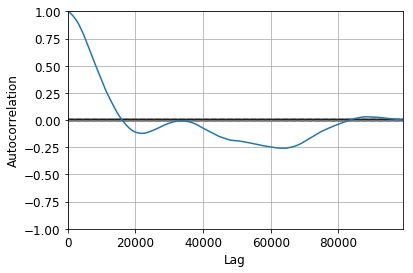

In [229]:
cut = data.set_index(pd.to_datetime(data.SUBMITTED,unit='s'))
cut = cut.sort_index()
autocorrelation_plot(cut.Q_TIME)

In [322]:
data = data.set_index(pd.to_datetime(data.SUBMITTED.values,unit='s'))
data = data.sort_index()
actives = []
for ti in data.SUBMITTED.values:
    sub = data[data.SUBMITTED <= ti]
    sub = sub[sub.STARTED > ti]
    actives.append(len(sub))
data['ACTIVE'] = actives

In [297]:
data.corr()

,SIZE,SUBMITTED,STARTED,ENDED,Q_TIME,N_RATE,T_TIME,ACTIVE
SIZE,1.000000,-0.216188,-0.215230,-0.214882,0.099302,0.681942,0.118970,-0.055329
SUBMITTED,-0.216188,1.000000,0.999853,0.999850,-0.215503,-0.322302,-0.217933,-0.065502
STARTED,-0.215230,0.999853,1.000000,0.999998,-0.198707,-0.321565,-0.201278,-0.060401
ENDED,-0.214882,0.999850,0.999998,1.000000,-0.198710,-0.321532,-0.201014,-0.060440
Q_TIME,0.099302,-0.215503,-0.198707,-0.198710,1.000000,0.108728,0.992425,0.303686
N_RATE,0.681942,-0.322302,-0.321565,-0.321532,0.108728,1.000000,0.110993,-0.065500
T_TIME,0.118970,-0.217933,-0.201278,-0.201014,0.992425,0.110993,1.000000,0.299261
ACTIVE,-0.055329,-0.065502,-0.060401,-0.060440,0.303686,-0.065500,0.299261,1.000000


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


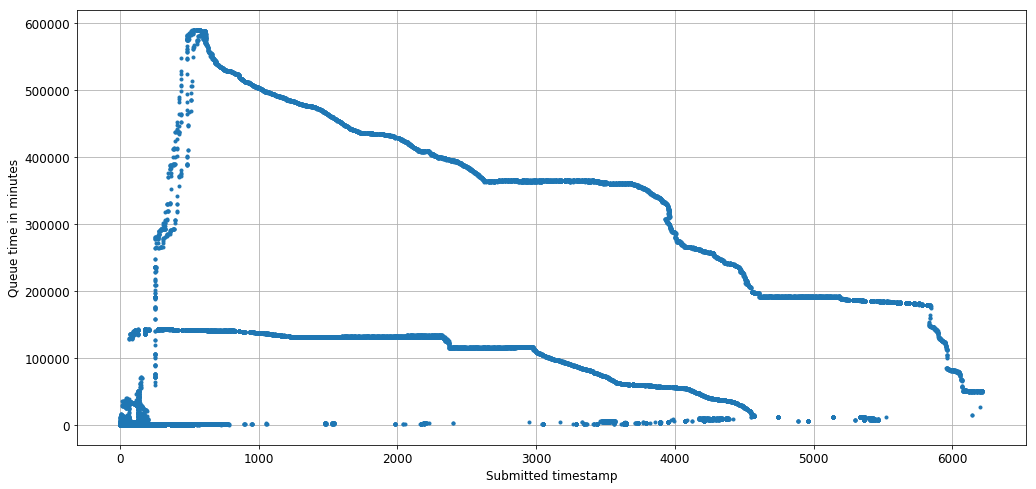

In [325]:
#plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'), data.Q_TIME.values/60.,'.', label='real')
#plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time')
#plt.plot(pd.to_datetime(data.ENDED.values,unit='s'), data.ACTIVE,'.',label='active')
plt.plot( data.ACTIVE,data.Q_TIME.values,'.')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

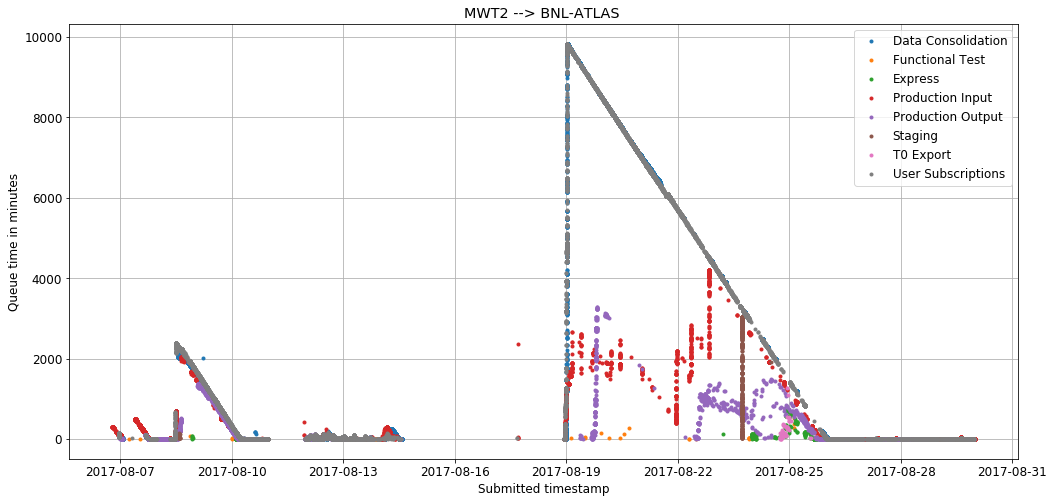

In [386]:
plt.title('%s --> %s '% (src,dst))
for act in ['Data Consolidation',
            'Functional Test',
            'Express', 
            'Production Input',
            'Production Output',
            'Staging',
            'T0 Export',
            'User Subscriptions'
           ]:
    cut = data[data.LINK == src+'__'+dst+'__'+act]
    plt.plot(pd.to_datetime(cut.SUBMITTED.values,unit='s'),cut.Q_TIME.values/60,'.', label=act)
#plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),(data.Q_TIME.values/60),'.k', label='real time',alpha=0.2)
#plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.r', label='possible real time',alpha=0.2)
#plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
#         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
#plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
#         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

66998 records retrieved for link AGLT2 --> MWT2 (User Subscriptions).
2.86028762275 5.38432528204


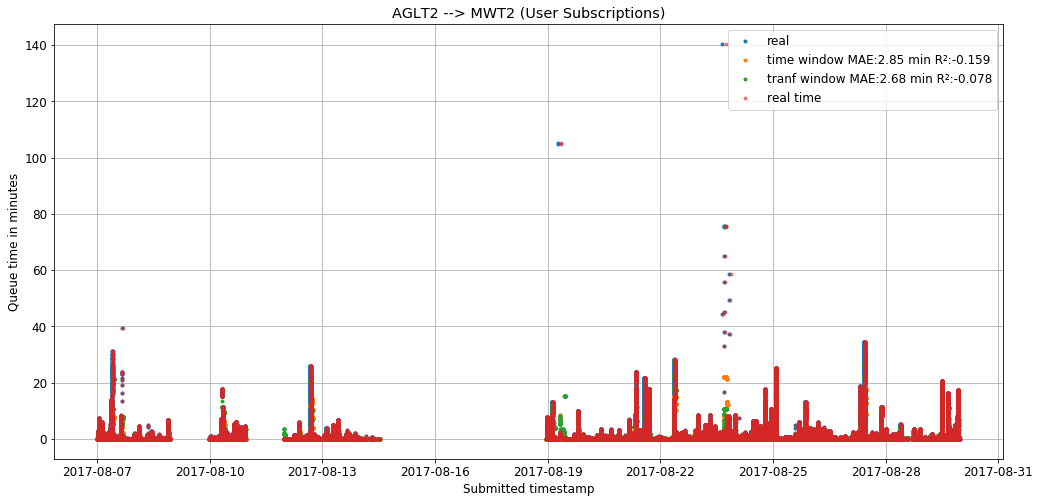

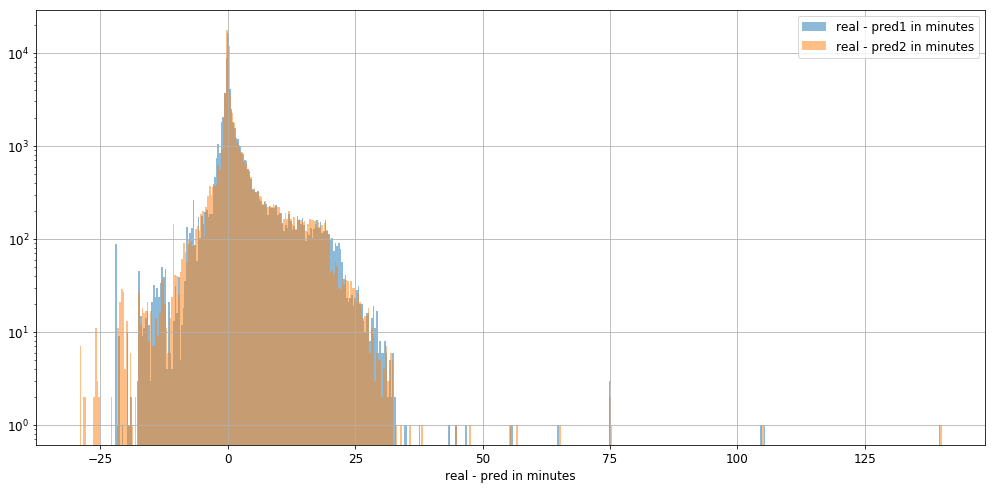

In [388]:
# link to test
src = 'AGLT2'
dst = 'MWT2'
act = 'User Subscriptions'
days = 24
# parameters for time based window
# window in minutes
window_1 = 60
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 50
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-07', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time',alpha=0.5)
#plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

88076 records retrieved for link MWT2 --> BNL-ATLAS (User Subscriptions).
1908.98252082 2772.39049844


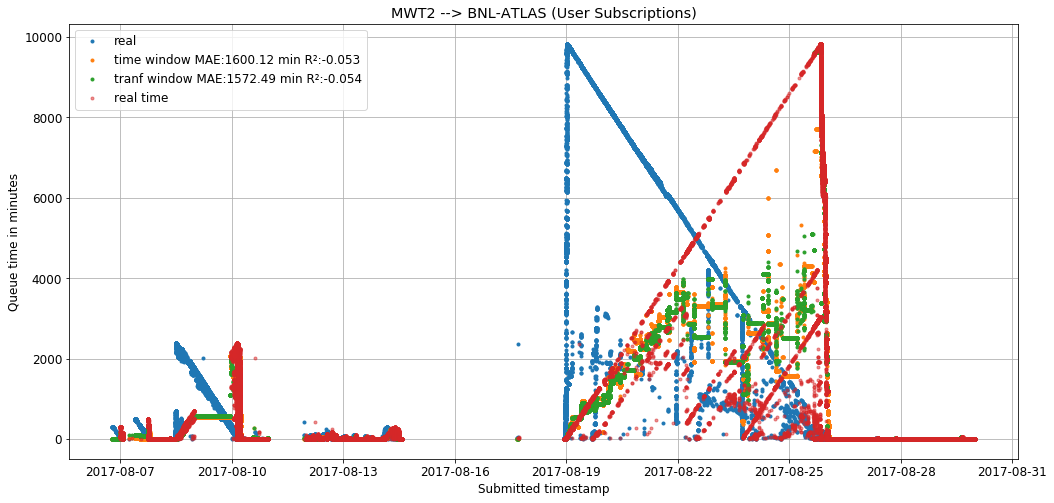

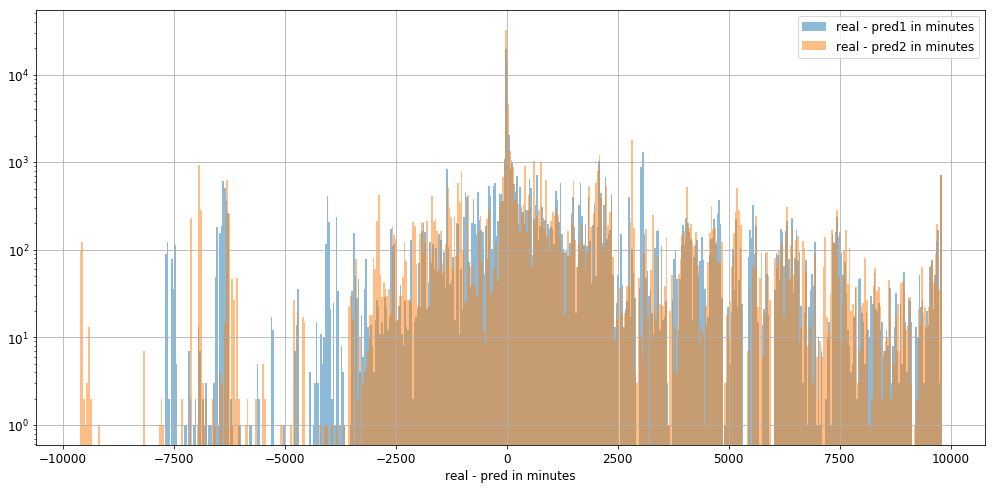

In [385]:
# link to test
src = 'MWT2'
dst = 'BNL-ATLAS'
act = 'User Subscriptions'
days = 24
# parameters for time based window
# window in minutes
window_1 = 60
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 50
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-07', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time',alpha=0.5)
#plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

38248 records retrieved for link BNL-ATLAS --> MWT2 (User Subscriptions).
1184.14178484 2274.76183442


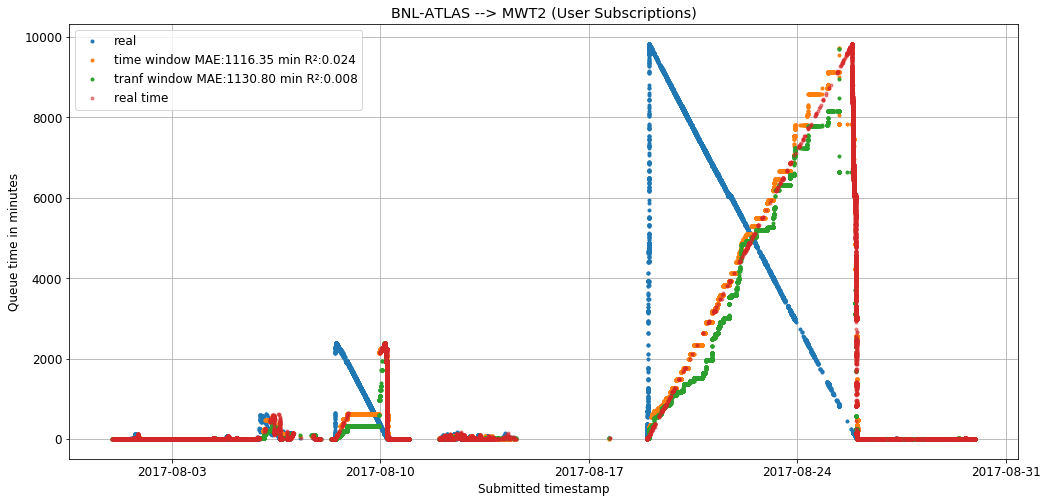

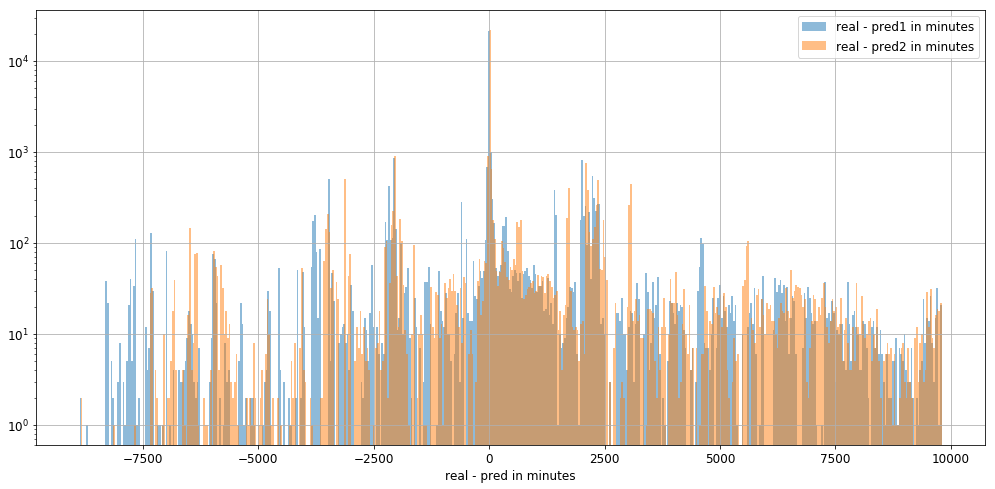

In [335]:
# link to test
src = 'BNL-ATLAS'
dst = 'MWT2'
act = 'User Subscriptions'
days = 30
# parameters for time based window
# window in minutes
window_1 = 60
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 50
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time',alpha=0.5)
#plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

98979 records retrieved for link BNL-ATLAS --> CERN-PROD (Data Consolidation).
2218.57737159 2997.35309946


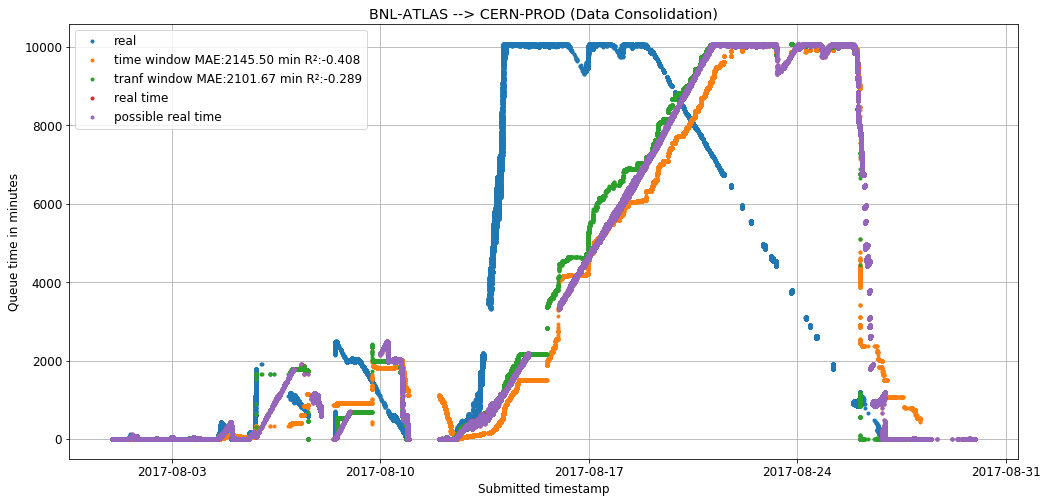

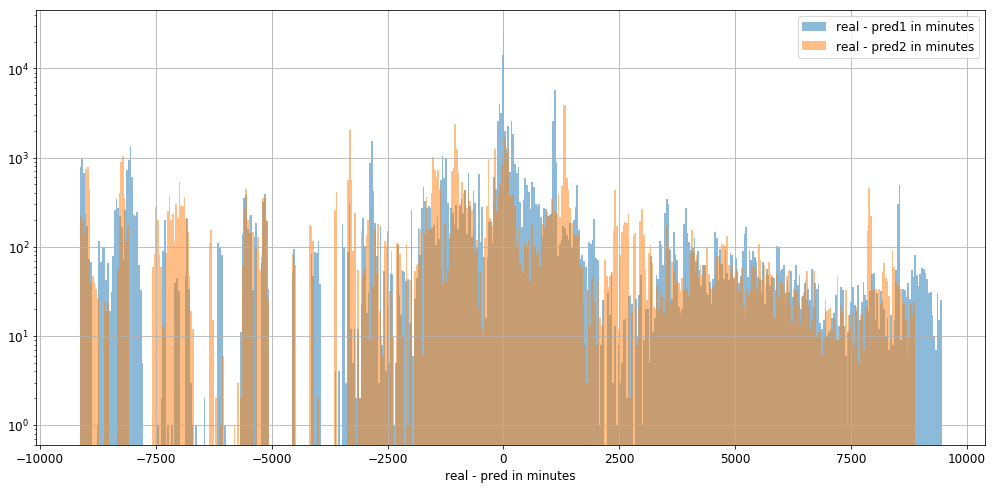

In [318]:
# link to test
src = 'BNL-ATLAS'
dst = 'CERN-PROD'
act = 'Data Consolidation'
days = 30
# parameters for time based window
# window in minutes
window_1 = 2385
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 5
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time')
plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

105696 records retrieved for link BNL-ATLAS --> CERN-PROD (User Subscriptions).
1495.3867131 2074.88405802


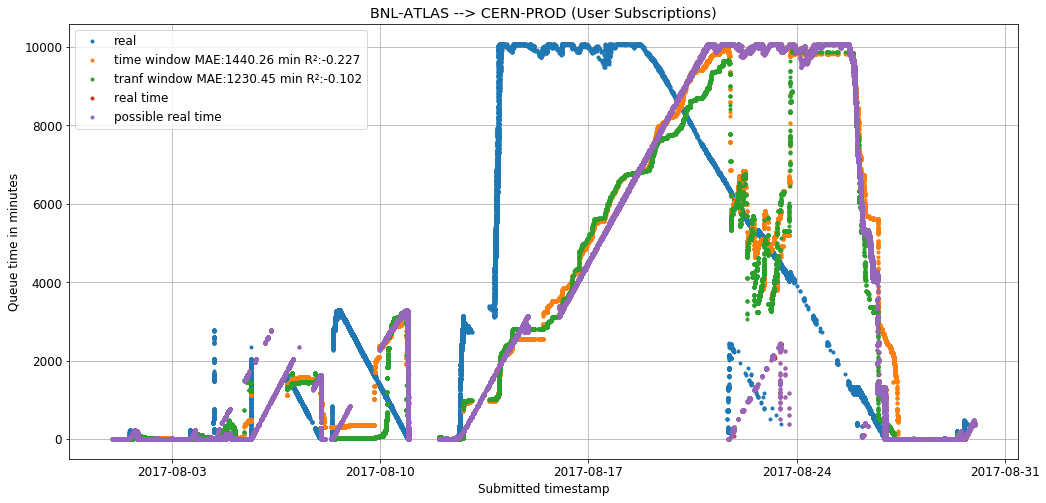

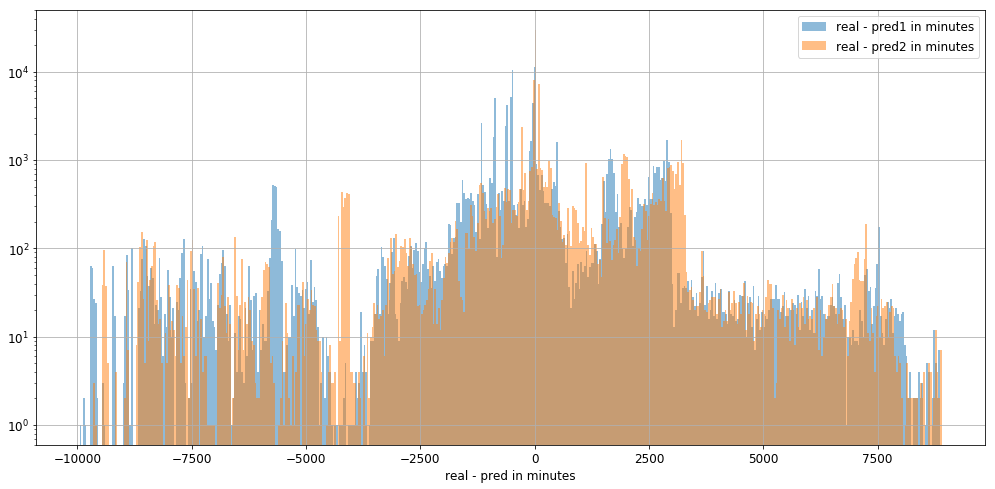

In [233]:
# link to test
src = 'BNL-ATLAS'
dst = 'CERN-PROD'
act = 'User Subscriptions'
days=30
# parameters for time based window
# window in minutes
window_1 = 1529
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 575
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time')
plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

38645 records retrieved for link CERN-PROD --> BNL-ATLAS (Data Consolidation).
2197.05210462 1383.84418453


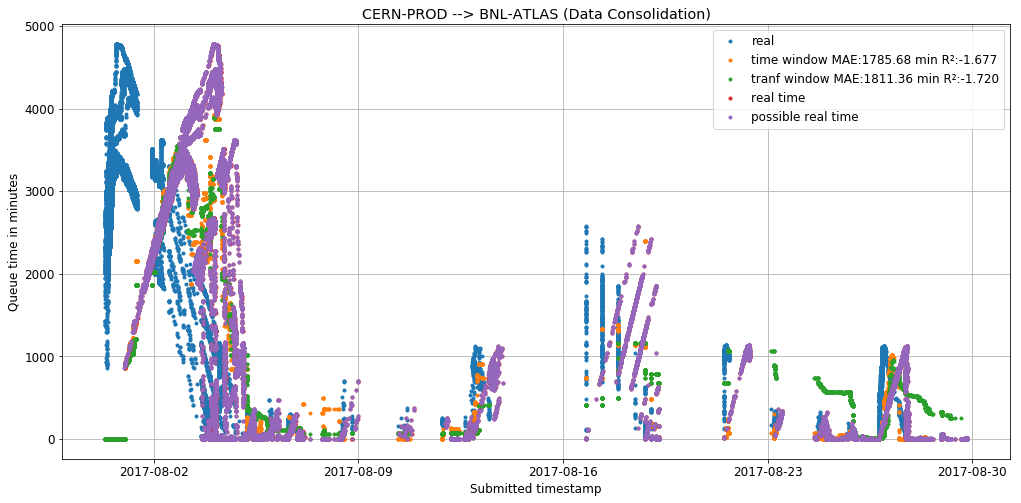

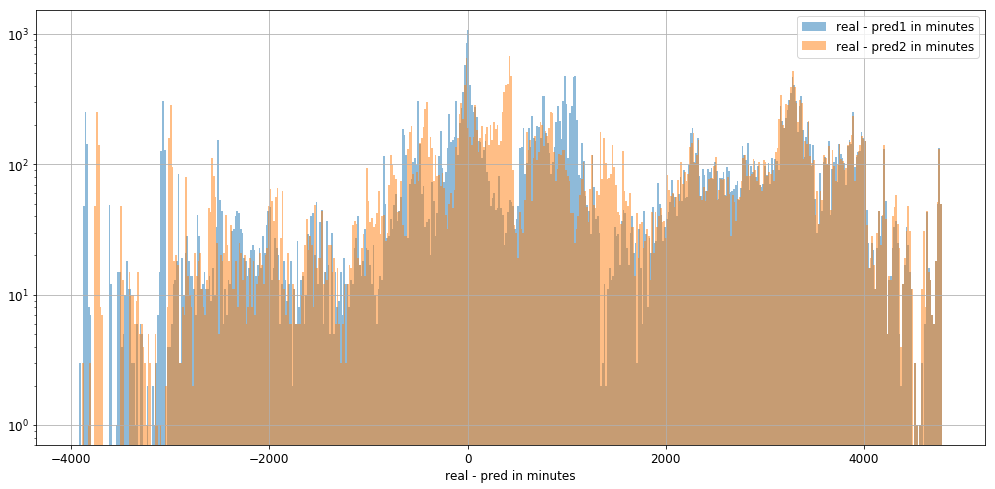

In [234]:
# link to test
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Data Consolidation'
days=30
# parameters for time based window
# window in minutes
window_1 = 75
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 952
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
plt.plot(pd.to_datetime(data.ENDED.values,unit='s'),data.Q_TIME.values/60,'.', label='real time')
plt.plot(pd.to_datetime(data.STARTED.values,unit='s'),data.Q_TIME.values/60,'.', label='possible real time')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

87845 records retrieved for link CERN-PROD --> BNL-ATLAS (User Subscriptions).
642.577676093 782.505075577


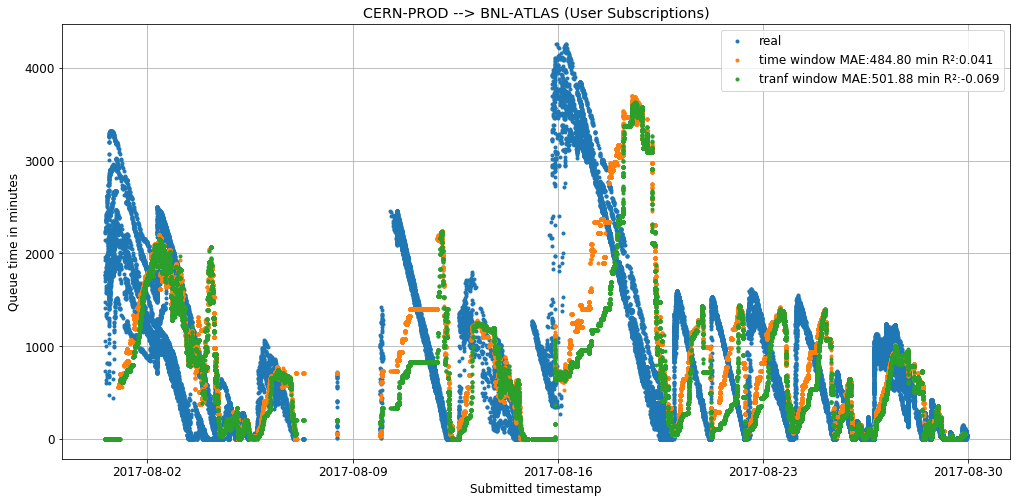

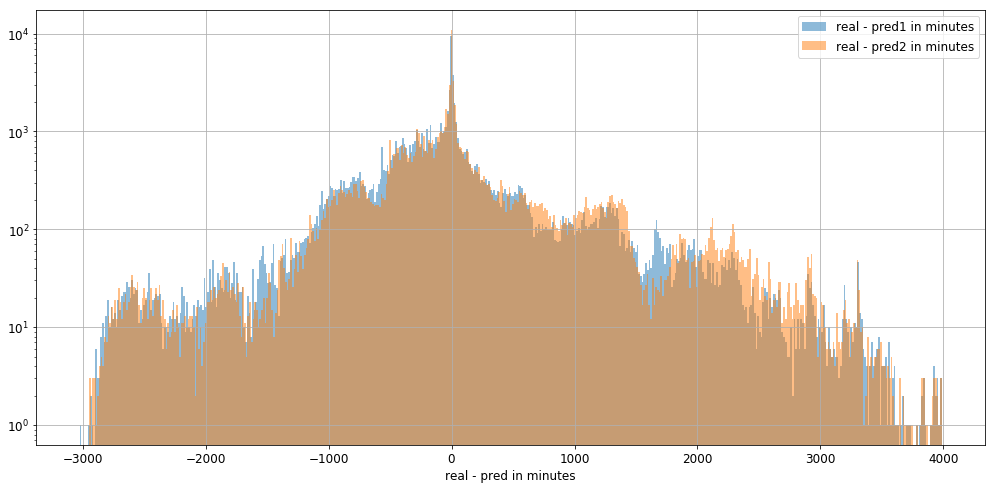

In [316]:
# link to test
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'User Subscriptions'
# parameters for time based window
# window in minutes
window_1 = 46
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 100
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', 30)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

40613 records retrieved for link CERN-PROD --> BNL-ATLAS (Production Input).
383.788568762 515.507100537


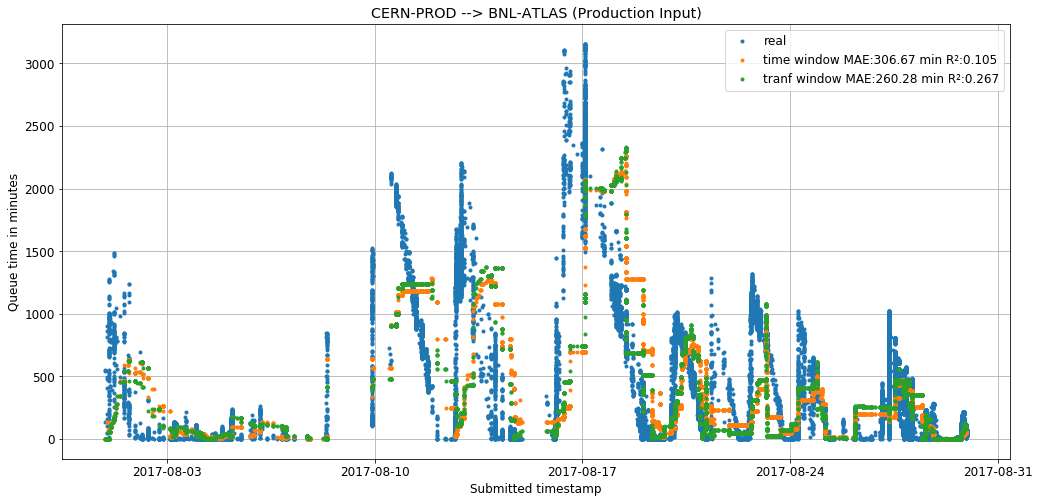

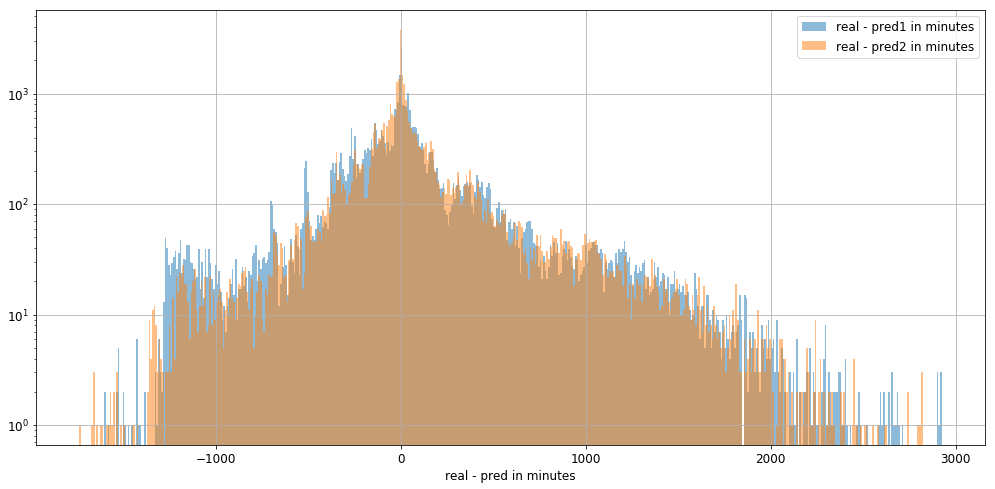

In [193]:
# link to test
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
# parameters for time based window
# window in minutes
window_1 = 661
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 100
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', 30)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()

fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

50292 records retrieved for link NDGF-T1 --> BNL-ATLAS (Production Input).
59.5048842376 132.38893821


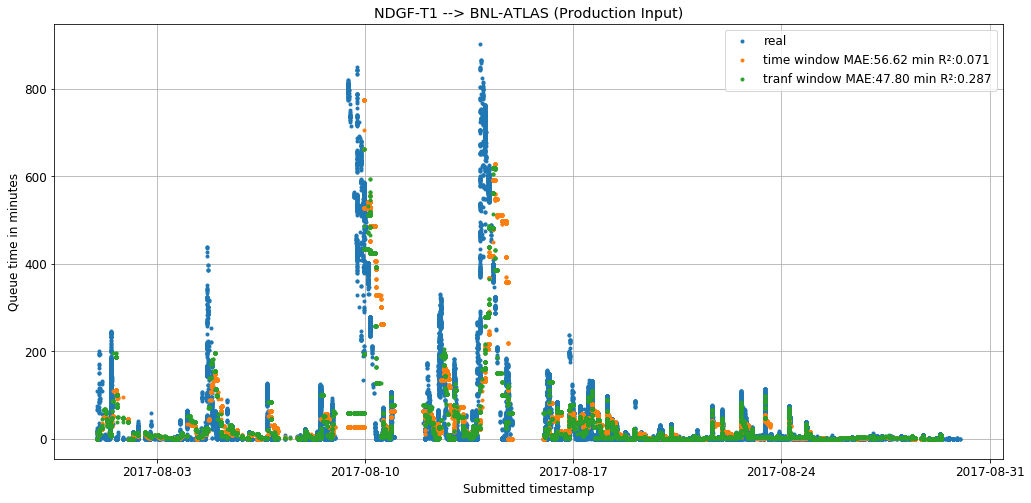

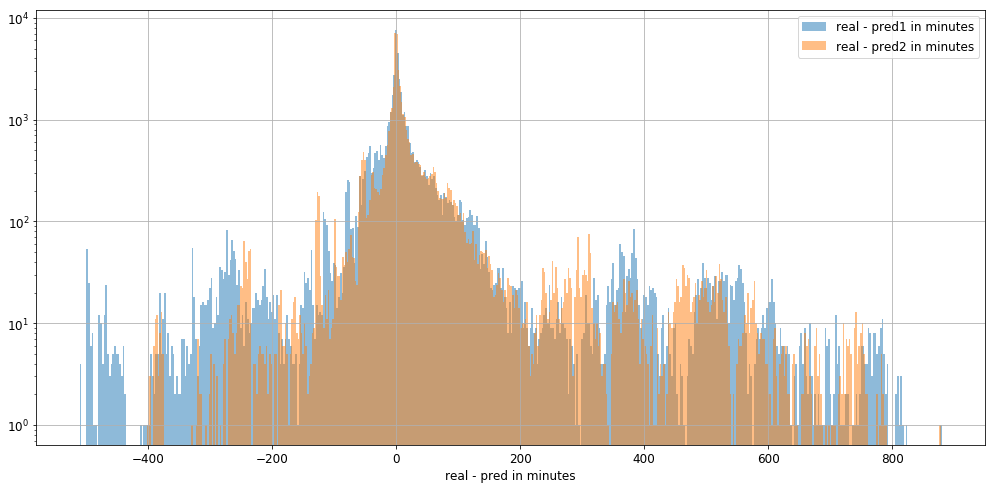

In [215]:
# link to test
src = 'NDGF-T1'
dst = 'BNL-ATLAS'
act = 'Production Input'
# parameters for time based window
# window in minutes
window_1 = 358
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 100
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', 30)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()

fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()